In [2]:
import pydicom
import cv2
import numpy as np
import pandas as pd
import csv
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [3]:
def hough_line(img):
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, (5, 5), 0)

    # Apply edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)

    # Thresholding
    _, thresholded = cv2.threshold(edges, 150, 255, cv2.THRESH_BINARY)
    lines = cv2.HoughLines(thresholded, 1, np.pi / 180, threshold=100)
    return lines

In [4]:
def canny_filter(img, lines):
    # Setting All parameters 
    t_lower = 100  # Lower Threshold 
    t_upper = 200  # Upper threshold 
    aperture_size = 5  # Aperture size 
    edge = cv2.Canny(img, t_lower, t_upper,  apertureSize=aperture_size) 
    return edge

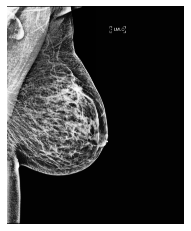

In [5]:
test_pic = "../../datasets/image/clean_png/after_clahe.png"

img = cv2.imread(test_pic,0)

# Read the PNG file
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

lines = hough_line(img)
canny_img = canny_filter(img, lines)

In [6]:
#apply mask on hough line
line_coordinates = []
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    line_coordinates.append(((x1, y1), (x2, y2)))

line_img = img.copy()
mask = np.zeros_like(img, dtype=np.uint8)
for line in line_coordinates:
    cv2.line(mask, line[0], line[1], 1, 2)
    cv2.line(line_img, line[0], line[1], 1, 2)

In [7]:
#with ROI

# Define the ROI as the upper left quarter of the preprocessed image
rows, cols = img.shape[:2]
roi_mask = np.zeros_like(img, dtype=np.uint8)
roi_mask[:rows//2, :cols//2] = 1

# Apply the ROI mask
masked_image = cv2.bitwise_and(mask, mask, mask=roi_mask)

# Find contours in the masked image
contours, _ = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# Draw the ROI on the original image
roi_image = cv2.drawContours(np.zeros_like(img), [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
result = cv2.bitwise_and(img, img, mask=roi_image)


#without ROI
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
roi_image = cv2.drawContours(np.zeros_like(img), [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
result = cv2.bitwise_and(img, img, mask=roi_image)


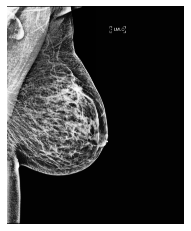

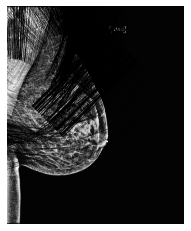

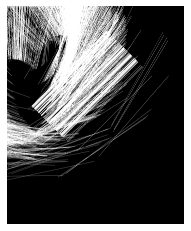

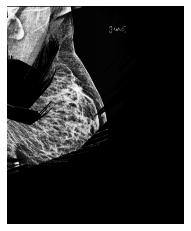

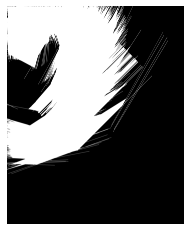

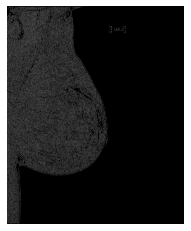

In [8]:
# Display the result
plt.imshow(img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(line_img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(mask, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(result, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(roi_image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

plt.imshow(canny_img, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

In [36]:
from skimage.feature import canny
from skimage.filters import sobel
def apply_canny(image):
    canny_img = canny(image, 3)
    return sobel(canny_img)

In [40]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [31]:
def shortlist_lines(lines):
    MIN_ANGLE = 25
    MAX_ANGLE = 40
    MIN_DIST  = 5
    MAX_DIST  = 250
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [28]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    # print(shortlisted_lines)
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [38]:
from matplotlib import pylab as pylab

def display_image(image):
    # print(image)
    canny_image = apply_canny(image)
    filtered_image = cv2.filter2D(canny_image, -1, np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))
    lines = get_hough_lines(filtered_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    # print(shortlisted_lines)
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()    

tested_angle:  [-1.57079633 -1.56206968 -1.55334303 -1.54461639 -1.53588974 -1.5271631
 -1.51843645 -1.5097098  -1.50098316 -1.49225651 -1.48352986 -1.47480322
 -1.46607657 -1.45734993 -1.44862328 -1.43989663 -1.43116999 -1.42244334
 -1.41371669 -1.40499005 -1.3962634  -1.38753676 -1.37881011 -1.37008346
 -1.36135682 -1.35263017 -1.34390352 -1.33517688 -1.32645023 -1.31772359
 -1.30899694 -1.30027029 -1.29154365 -1.282817   -1.27409035 -1.26536371
 -1.25663706 -1.24791042 -1.23918377 -1.23045712 -1.22173048 -1.21300383
 -1.20427718 -1.19555054 -1.18682389 -1.17809725 -1.1693706  -1.16064395
 -1.15191731 -1.14319066 -1.13446401 -1.12573737 -1.11701072 -1.10828408
 -1.09955743 -1.09083078 -1.08210414 -1.07337749 -1.06465084 -1.0559242
 -1.04719755 -1.0384709  -1.02974426 -1.02101761 -1.01229097 -1.00356432
 -0.99483767 -0.98611103 -0.97738438 -0.96865773 -0.95993109 -0.95120444
 -0.9424778  -0.93375115 -0.9250245  -0.91629786 -0.90757121 -0.89884456
 -0.89011792 -0.88139127 -0.87266463 -

IndexError: list index out of range

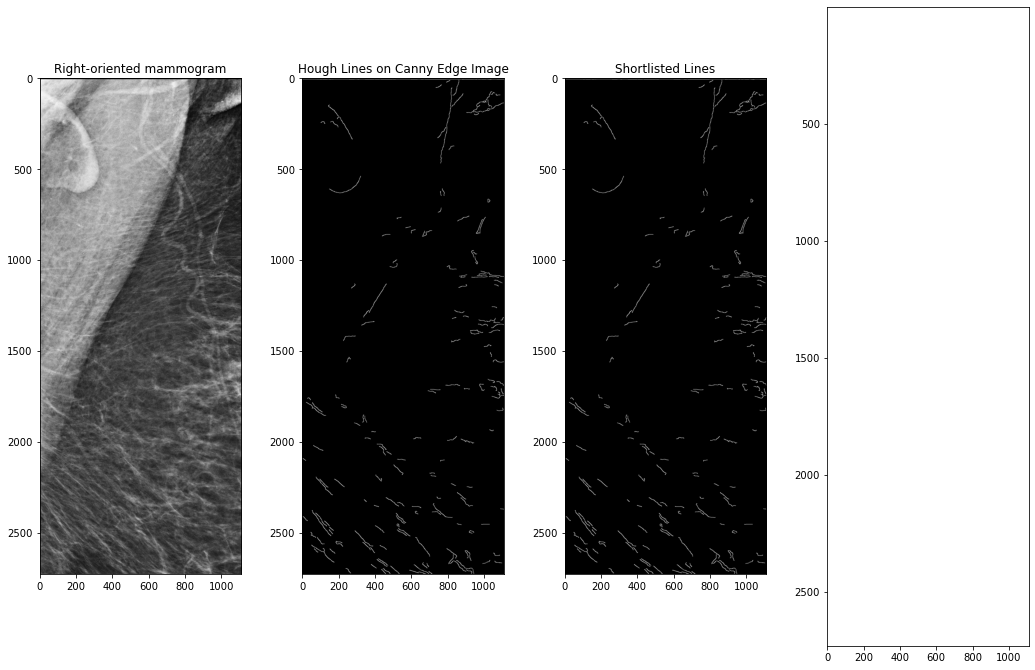

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
import cv2

test_pic = "../../datasets/image/clean_png/muscle.png"
image = cv2.imread(test_pic, 0)
rows, cols = image.shape
roi = image[:2 * rows//3, :cols//3]
# print(roi)
display_image(roi)

In [1]:
import cv2
import numpy as np

# Read the image
test_pic = "../../datasets/image/clean_png/after_clahe.png"
ori_pic = "../../datasets/image/clean_png/muscle.png"

image = cv2.imread(test_pic, 0)
ori_image = cv2.imread(ori_pic, 0)

# Step 1: Find the region of interest (ROI)
rows, cols = ori_image.shape
roi = ori_image[:2 * rows//3, :cols//3]
image_roi = image[:2 * rows//3, :cols//3]
rows, cols = roi.shape

# Step 2: Contour detection using Canny filter
# blurred = cv2.GaussianBlur(roi, (5, 5), 0)
canny_output = cv2.Canny(roi, 110, 220)
# canny_output = apply_canny(roi)

# Step 3: Linear aperture filtering
filtered_image = cv2.filter2D(canny_output, -1, np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]]))

# Step 4: Line detection using Hough Transform
# lines = get_hough_lines(filtered_image)
# shortlisted_lines = shortlist_lines(lines)
# _, thresholded = cv2.threshold(filtered_image, 150, 255, cv2.THRESH_BINARY)
# lines = cv2.HoughLines(thresholded, 1, np.pi / 180, threshold=180)
# line_coordinates = []
# for line in lines:
#     rho, theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a * rho
#     y0 = b * rho
#     x1 = int(x0 + 1000 * (-b))
#     y1 = int(y0 + 1000 * (a))
#     x2 = int(x0 - 1000 * (-b))
#     y2 = int(y0 - 1000 * (a))
#     line_coordinates.append(((x1, y1), (x2, y2)))

# hough_mask = np.zeros_like(filtered_image)
# for line in line_coordinates:
#     cv2.line(hough_mask, line[0], line[1], 255, 2)

# theta_min = 25 * np.pi / 180
# theta_max = 40 * np.pi / 180
# rho_min = 1
# rho_max = int(np.sqrt(rows**2 + cols**2))

# print(rows, cols)

# # Initialize the accumulator
# accumulator = np.zeros((rho_max, int((theta_max / (np.pi / 180) - theta_min / (np.pi / 180)))), dtype=np.uint64)

# # For each pixel (x, y) of the image, calculate ρ = x * Cos θ + y * Sin θ
# for x in range(rows):
#     for y in range(cols):
#         for theta in range(int(theta_min * 180 / np.pi), int(theta_max * 180 / np.pi)):
#             theta_rad = theta * np.pi / 180
#             rho = int(x * np.cos(theta_rad) + y * np.sin(theta_rad))
#             theta_tmp = theta - int(theta_min * 180 / np.pi)
#             accumulator[rho, theta_tmp] += 1
#             # print(rho, theta)

# # Find the coordinates of non-zero elements in the accumulator
# peak_coordinates = np.argwhere(accumulator > 0)

# Find the maximum value(s) in the accumulator
# max_values = accumulator.max()

# Print or use the peak coordinates and max values as needed
# for peak in peak_coordinates:
#     rho, theta_tmp = peak

#     # Convert theta back to radians
#     theta_rad = theta * np.pi / 180

#     # Creation of the Hough mask
#     # Ensure the correct size and type for hough_mask
#     hough_mask = np.zeros_like(roi)
#     cv2.line(hough_mask, (int(theta_rad), int(rho)), (int(theta_rad), int(rho)), 255, 2)

# Step 6: Apply the Hough mask to the region of interest
# Assuming hough_mask is a binary mask
# rr, cc = remove_pectoral(shortlisted_lines)
# hough_mask = np.zeros_like(filtered_image)
# hough_mask[rr, cc] = 0
# inverse_mask = cv2.bitwise_not(hough_mask)

# # Apply the inverse mask to the original image
# result = cv2.bitwise_and(image_roi, image_roi, mask=inverse_mask)

# Display the results
cv2.imshow('Original Image', image)
cv2.imshow('Region of Interest (ROI)', image_roi)
# cv2.imshow('Blurred', blurred)
cv2.imshow('Canny Filter', canny_output)
cv2.imshow('Filtered Image', filtered_image)
# cv2.imshow('Hough Mask', hough_mask)
# cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import numpy as np

# Read the image
test_pic = "../../datasets/image/clean_png/after_clahe.png"
ori_pic = "../../datasets/image/clean_png/muscle.png"

image = cv2.imread(test_pic, cv2.IMREAD_GRAYSCALE)
ori_image = cv2.imread(ori_pic, cv2.IMREAD_GRAYSCALE)

rows, cols = ori_image.shape
roi = ori_image[:2 * rows//3, :cols//3]

# Define a threshold value
threshold_value = 160

# Iterate over each pixel in the image
for i in range(roi.shape[0]):
    for j in range(roi.shape[1]):
        # Apply threshold to each pixel individually
        if ori_image[i, j] > threshold_value:
            ori_image[i, j] = 255
        else:
            ori_image[i, j] = 0
        # print(roi[i,j], end=' ')
    print('\n')

# Display the results
# cv2.imshow('Original Image', ori_image)
cv2.imshow('Thresholded Image', ori_image)
cv2.waitKey(0)
cv2.destroyAllWindows()